Preference profile file: tests/ED-00006-00000021.soc
By choosing profiles[1, 3, 6], 3 voters are included


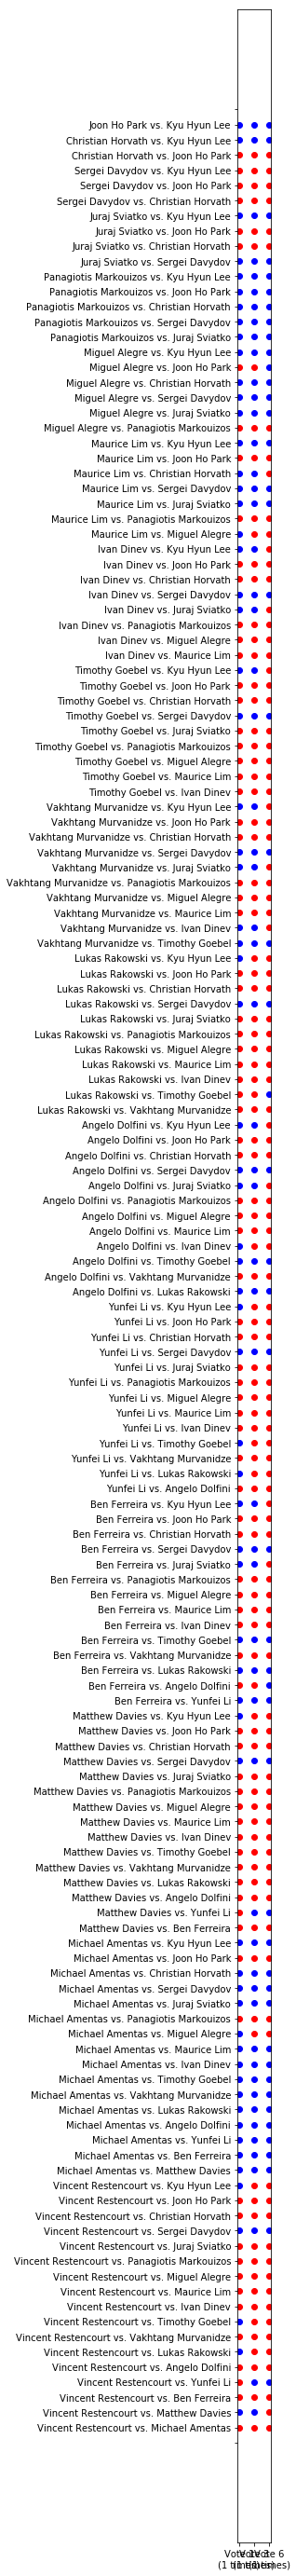

In [23]:
from preflibtools import io
import numpy as np
import networkx as nx
import matplotlib as mpl
from matplotlib import pyplot as plt

def diff_orders(rank_maps, prev_rank, num_cand):
  """ Calculates the delta(<, <^) = {{a,b}| a < b and b <^ a}"""
  delta = []
  for rank_map in rank_maps:
      d = set([])
      for c1 in range(1, num_cand+1):
          for c2 in range(1, num_cand+1):
              if prev_rank[c1] < prev_rank[c2] and rank_map[c2] < rank_map[c1]:
                  d.add((c1, c2))
      delta.append(d)
  return delta
  

def build_graph(root, rank_maps, counts, num_cand):
  """ Builds n subgraphs starting at U_i_i """
  votes = len(rank_maps)
  dag = nx.DiGraph()
  dag.add_nodes_from(range(votes))
  delta = diff_orders(rank_maps, rank_maps[root], num_cand)
  for v1 in range(votes):
      for v2 in range(votes):
          if v1!=v2 and delta[v1].issubset(delta[v2]):
              dag.add_weighted_edges_from([(v1,v2,counts[v2])])
  return dag

def total_voters(path, counts):
    s = 0
    for v in path:
        s = s + counts[v]
    return s
            
def plot_sc(voters, rank_maps, cand_map, counts):
    num_cand = len(cand_map)
    num_pairs = 0
    ylabels = ['']
    xlabels = list(map(lambda x: 'Vote '+ str(x) + '\n(' + str(counts[x]) + ' times)', voters))
    for a in range(num_cand):
        for b in range(a + 1, num_cand):
            ylabels.append(cand_map[a+1] + ' vs. ' + cand_map[b+1])
            num_pairs = num_pairs + 1
            prefer_a = []
            prefer_b = []
            for v_idx in range(len(voters)):
                v = voters[v_idx]
                if rank_maps[v][a+1] < rank_maps[v][b+1]: #candidates are indexed from 1
                    prefer_a.append(v_idx)
                else:
                    prefer_b.append(v_idx)
            plt.plot(prefer_a, np.full_like(prefer_a, num_pairs), 'ro', 
                     prefer_b, np.full_like(prefer_b, num_pairs), 'bo')
    plt.xticks(np.arange(0, len(voters), 1.0), xlabels)
    plt.yticks(np.arange(0, num_pairs + 2, 1.0), ylabels)
    plt.axis('scaled')
    fig = plt.gcf()
    fig.set_size_inches(50, 50)
    plt.show()
    
def main():
  filename = input("Preference profile file: ")
  input_file = open(filename, 'r')
  cand_map, rank_maps, rank_map_counts, num_voters = io.read_election_file(input_file)
  num_cand = len(rank_maps)
  solution = 0
  for i in range(num_cand):
    dag = build_graph(i, rank_maps, rank_map_counts, len(cand_map))
    path = nx.dag_longest_path(dag, weight='weight')
    voters = total_voters(path, rank_map_counts)
    if voters > solution:
        solution = voters
        sc_path = path
  print("By choosing profiles" + str(sc_path) + ", " + str(solution) + " voters are included")
  plot_sc(sc_path, rank_maps, cand_map, rank_map_counts)
if __name__ == "__main__":
  main()